# Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
from ropwr import RobustPWRegression
from optbinning.binning.outlier import RangeDetector

## Basic

To get us started, let’s load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [3]:
class Data:
    def __init__(self, data, target, feature_names):
        self.data = data
        self.target = target
        self.feature_names = feature_names


def load_boston():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
    raw_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                     'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

    return Data(raw_data, target, feature_names)

In [4]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

To ease the representation of the solution and performance metrics, we use the following auxiliary function.

In [5]:
def report(x, y, pw, splits, alpha=0.5):
    idx = np.argsort(x)
    xs = x[idx]
    ys = y[idx]
    pred = pw.predict(xs)

    mse = mean_squared_error(y_true=ys, y_pred=pred)
    mae = mean_absolute_error(y_true=ys, y_pred=pred)

    plt.plot(xs, ys, 'o', alpha=alpha)
    plt.plot(xs, pred, '-', linewidth=2, label=f"MSE={mse:.3f}. MAE={mae:.3f}")

    for s in splits:
        plt.axvline(s, color="grey", linestyle="--")
        
    plt.legend()
    plt.show()

Until version 0.3.0 the user was required to provide a list of split points. Since version 0.4.0 two unsupervised binning techniques, equal-size ("uniform") and equal-frequency interval ("quantile") from scikit-learn ``KBinsDiscretizer`` are available. To make this tutorial compatible with previous versions, we compute the split points externally.

In [6]:
variable = "AGE"
x = df[variable].values
y = data.target

In [7]:
est = KBinsDiscretizer(n_bins=10, strategy="quantile")
est.fit(x.reshape(-1, 1), y)
splits = est.bin_edges_[0][1:-1]

There are 9 split points, therefore 10 bins.

In [8]:
splits

array([26.95, 37.8 , 52.4 , 65.4 , 77.5 , 85.9 , 91.8 , 95.6 , 98.8 ])

Import and instantiate an ``RobustPWRegression`` object class. Then we call ``fit`` with arrays ``x``, ``y`` and ``splits``. 

In [9]:
pw = RobustPWRegression()

In [10]:
pw.fit(x, y, splits)

RobustPWRegression()

The attribute ``coef_``returns the coefficients of the piecewise regression for each bin.

In [11]:
pw.coef_

array([[ 2.63677424e+01,  8.02505909e-02],
       [ 3.54433847e+01, -2.56507939e-01],
       [ 2.81643952e+01, -6.39420794e-02],
       [ 2.28603838e+01,  3.72795133e-02],
       [ 4.20632314e+01, -2.56342009e-01],
       [ 3.10243037e+01, -1.13904232e-01],
       [ 2.00180639e+01,  1.42242861e-02],
       [ 1.14218262e+02, -1.01192166e+00],
       [ 1.97364661e+01, -2.36183578e-02],
       [ 6.16982408e+01, -4.48332677e-01]])

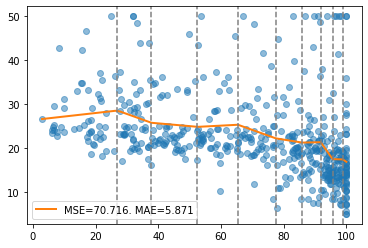

In [12]:
report(x, y, pw, splits)

By default, a continuous piecewise regression is fitted, however, this constraint can be deactivated using ``continuous=False``.

In [13]:
pw = RobustPWRegression(continuous=False)
pw.fit(x, y, splits=splits)

RobustPWRegression(continuous=False)

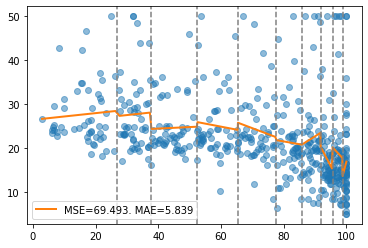

In [14]:
report(x, y, pw, splits)

### Monotonicity

In many applications, it is required to impose certain monotonicity constraints on some features. Six monotonic trends are considered: ascending, descending, convex, concave, peak and valley.

Version 1.0.0 introduced the option to fit a smooth degree $d$-polynomial with $d-1$ continuity in derivatives (splines). By default ``continuous_deriv`` is set to True.

In the following, we minimize the $l_1-$norm with a quadratic function impose descending monotonicity.

In [15]:
pw = RobustPWRegression(objective="l1", degree=2, continuous_deriv=False,
                        monotonic_trend="descending")
pw.fit(x, y, splits)

RobustPWRegression(continuous_deriv=False, degree=2,
                   monotonic_trend='descending', objective='l1')

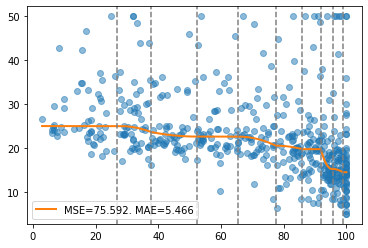

In [16]:
report(x, y, pw, splits)

Similar, using the Huber function as an objective.

In [17]:
pw = RobustPWRegression(objective="huber", degree=2, continuous_deriv=False,
                        monotonic_trend="descending")
pw.fit(x, y, splits)

RobustPWRegression(continuous_deriv=False, degree=2,
                   monotonic_trend='descending', objective='huber')

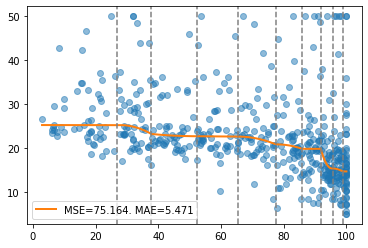

In [18]:
report(x, y, pw, splits)

Now, we select a different variable for testing other basic options. This variable shows a less steady relationship with the target.

In [19]:
variable = "NOX"
x = df[variable].values
y = data.target

In [20]:
est = KBinsDiscretizer(n_bins=10, strategy="quantile")
est.fit(x.reshape(-1, 1), y)
splits = est.bin_edges_[0][1:-1]

In [21]:
pw = RobustPWRegression(objective="l2", degree=1, monotonic_trend=None)
pw.fit(x, y, splits)

RobustPWRegression()

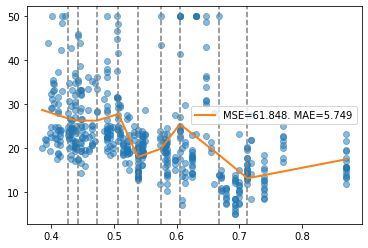

In [22]:
report(x, y, pw, splits)

The relationship with the target exhibits a sort of U-shaped trend. Let's try to force convexity.

In [23]:
pw = RobustPWRegression(objective="l1", degree=1, monotonic_trend="convex")
pw.fit(x, y, splits)

RobustPWRegression(monotonic_trend='convex', objective='l1')

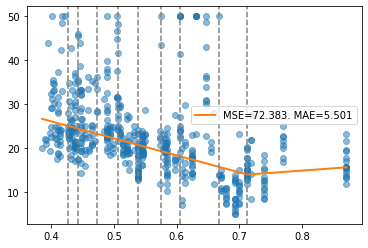

In [24]:
report(x, y, pw, splits)

To reduce the mean squared error (MSE) and mean absolute error (MAE), we replace convex by valley.

In [25]:
pw = RobustPWRegression(objective="l1", degree=1, monotonic_trend="valley")
pw.fit(x, y, splits)

RobustPWRegression(monotonic_trend='valley', objective='l1')

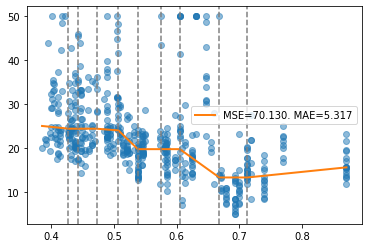

In [26]:
report(x, y, pw, splits)

Note that, for degree >= 2 and convex/concave monotonicity, the monotonicity constraint is only satisfied at each bin individually. For this case, selecting $l_1$-norm, we notice that the LP solver HIGHS performs better.

In [27]:
pw = RobustPWRegression(objective="l1", degree=3, continuous_deriv=False,
                        monotonic_trend="convex", solver="highs")
pw.fit(x, y, splits)

RobustPWRegression(continuous_deriv=False, degree=3, monotonic_trend='convex',
                   objective='l1', solver='highs')

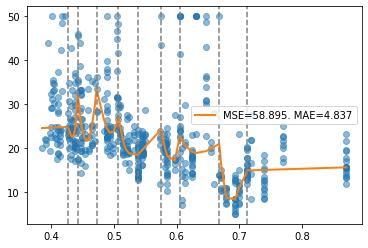

In [28]:
report(x, y, pw, splits)

For those cases, we recommend avoiding splits points and fit a polynomial directly or constraining continuous derivatives at the split point.

In [29]:
pw = RobustPWRegression(objective="l1", degree=3, monotonic_trend="convex")
pw.fit(x, y, splits=None)

RobustPWRegression(degree=3, monotonic_trend='convex', objective='l1')

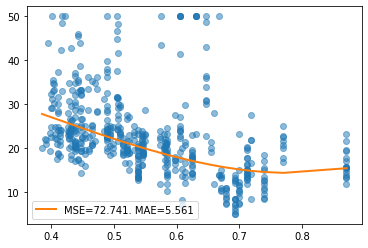

In [30]:
report(x, y, pw, splits=[])

In [31]:
pw = RobustPWRegression(objective="l1", degree=3, continuous_deriv=True,
                        monotonic_trend="convex", solver="highs")
pw.fit(x, y, splits)

RobustPWRegression(degree=3, monotonic_trend='convex', objective='l1',
                   solver='highs')

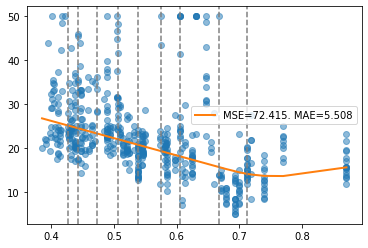

In [32]:
report(x, y, pw, splits)

## Advanced

For the advanced section, we load a larger dataset.

In [33]:
data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target
x = df["MedInc"].values
y = df["target"].values

In [34]:
est = KBinsDiscretizer(n_bins=15, strategy="quantile")
est.fit(x.reshape(-1, 1), y)
splits = est.bin_edges_[0][1:-1]

If the trend of the relationship with the target is unclear, use the default piecewise regression.

In [35]:
pw = RobustPWRegression(solver="osqp")
pw.fit(x, y, splits)

RobustPWRegression(solver='osqp')

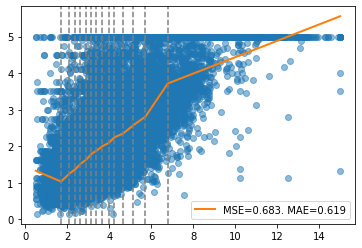

In [36]:
report(x, y, pw, splits)

We observe an ascending monotonic trend. Let's impose ascending monotonicity and show the solver's output.

In [37]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending", verbose=True)
pw.fit(x, y, splits)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Dec 17 11:18:50 PM: Your problem has 30 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 17 11:18:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 11:18:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 11:18:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 11:18:50 PM: Compiling problem (target solver=OSQP).
(CVXPY) Dec 17 11:18:50 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

RobustPWRegression(monotonic_trend='ascending', verbose=True)

The Quadratic Programming (QP) solver OSQP (``solver="osqp"``) is chosen. The option ``solver="auto"`` selects the most appropriate solver given the user's parameters. We can switch to the ECOS solver using ``solver="ecos"``.

In [38]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending", solver="ecos",
                        verbose=True)
pw.fit(x, y, splits)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Dec 17 11:18:58 PM: Your problem has 30 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 17 11:18:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 11:18:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 11:18:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 11:18:58 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 17 11:18:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

RobustPWRegression(monotonic_trend='ascending', solver='ecos', verbose=True)

Note that ECOS is significantly slower for this problem. However, the Second Order Cone Programming (SOCP) solver ECOS is more versatile, handling all the objectives and regularizations options available. Additionally, is better suited for large problems occurring when bounds are imposed.

### Regularization

A regularization term using $l_1-$norm (Lasso) $l_2-$norm (Ridge) can be added to the objective function.

In [39]:
pw = RobustPWRegression(objective="huber", monotonic_trend="ascending",
                        degree=2, regularization="l1", verbose=True)
pw.fit(x, y, splits)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Dec 17 11:19:07 PM: Your problem has 45 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 17 11:19:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 11:19:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 11:19:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 11:19:07 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 17 11:19:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

RobustPWRegression(degree=2, monotonic_trend='ascending', objective='huber',
                   regularization='l1', verbose=True)

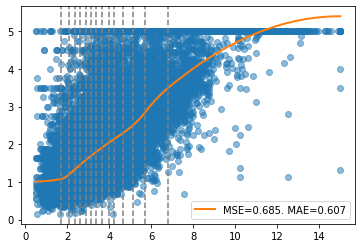

In [40]:
report(x, y, pw, splits)

In [41]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending",
                        regularization="l2", verbose=True)
pw.fit(x, y, splits)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Dec 17 11:19:17 PM: Your problem has 30 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 17 11:19:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 11:19:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 11:19:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 11:19:17 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 17 11:19:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

RobustPWRegression(monotonic_trend='ascending', regularization='l2',
                   verbose=True)

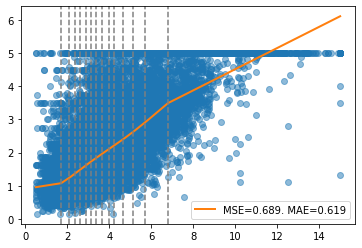

In [42]:
report(x, y, pw, splits)

Increasing the regularization term using parameters ``reg_l1`` and ``reg_l2`` will produce a smoother piecewise
regression.

### Lower and upper bound

In some circumstances, it is required to impose a lower or upper limit to the prediction. For example, if we are predicting house prices, we might need to fix a minimum and maximum price. Parameters ``lb`` and ``ub`` in method ``fit`` impose these constraints.

In [43]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending", verbose=True)
pw.fit(x, y, splits, lb=1, ub=5)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Dec 17 11:19:31 PM: Your problem has 30 variables, 4 constraints, and 0 parameters.
(CVXPY) Dec 17 11:19:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 11:19:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 11:19:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 11:19:31 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 17 11:19:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

RobustPWRegression(monotonic_trend='ascending', verbose=True)

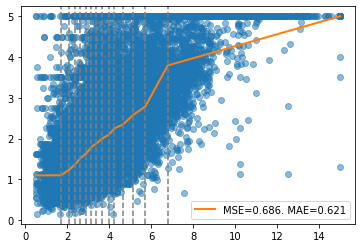

In [44]:
report(x, y, pw, splits)

As previously mentioned, ECOS is more adequate when bounds are active. OSQP requires more than 11 seconds to solve this problem and returns an inacurate solution. For large scale problems, a general alternative is the solver SCS.

In [45]:
pw = RobustPWRegression(objective="l2", solver="scs", monotonic_trend="ascending",
                        verbose=True)
pw.fit(x, y, splits, lb=1, ub=5)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Dec 17 11:19:49 PM: Your problem has 30 variables, 4 constraints, and 0 parameters.
(CVXPY) Dec 17 11:19:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 17 11:19:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 17 11:19:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 17 11:19:49 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 17 11:19:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> 

RobustPWRegression(monotonic_trend='ascending', solver='scs', verbose=True)